# Projet IA: Fashion Ethic

## Scrapping des données

In [ ]:
#pip install xgboost

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import re
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats 
import plotly.graph_objs as go
import plotly.subplots as sp
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from scipy.stats import randint

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score,confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split,RandomizedSearchCV


import matplotlib
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(color_codes=True)

c:\Users\serge\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


- Récupération de toute la collection Tendance Fashion (articles,prices,n_color,instocks)

In [ ]:
# All fashion collection
def Apparel(n):
    T = []
    P = []
    R = []
    S = []
    C = []
    Sz = []
    s = 0
    j = 0
    k = 0
    for i in range(1, n):
        url = (
            "https://www.tendancefashion.fr/fr/28-toute-la-collection?order=product.position.asc&page="
            + str(i)
            + ".html"
        )
        r = requests.get(url)
        soup = BeautifulSoup(r.text, "html.parser")
        Titles = soup.find_all("h1", {"class": "product-title"})
        Prices = soup.find_all("span", {"price"})
        Stocks = soup.find_all("div", {"product-add-to-cart"})
        Colors = soup.find_all("div", {"wt_color"})
        Sizes = soup.find_all("div", {"wt_size"})

        # Titles
        for t in Titles:
            T.append(t.a.text.strip())
            s = s + 1
        # Prices
        for t in Prices:
            t = re.sub(r"[^0-9.,]", "", t.text)
            P.append(float(t.replace(",", ".")))
        # In stocks
        for tag in Stocks:
            if "Ajouter" in tag.form.a.span.text:
                S.append(True)
            else:
                S.append(False)
        # N_colors
        for c in Colors:
            C.append(len(c.ul.find_all("li")))
            j = j + 1
        #
        # N_size
        for siz in Sizes:
            Sz.append(len(siz.ul.find_all("li")))
            k = k + 1
        # mis au point
    if j != i:
        while j != s:
            C.append(random.randint(min(C), max(C)))
            j = j + 1

    if k != i:
        while k != s:
            Sz.append(random.randint(min(Sz), max(Sz)))
            k = k + 1
    return {"Articles": T, "Prices": P, "InStocks": S, "N_colors": C, "N_sizes": Sz}


In [45]:
df = Apparel(248)

In [46]:
 Fashion_collection = pd.DataFrame(df)

In [47]:
 Fashion_collection.to_csv('Fashion_collection.csv',index=False)

- Récupération des meilleurs ventes Tendance Fashion (articles,prices,n_color,instocks)

In [48]:
# best sell fashion
def bestApparel(n):
    T = []
    P = []
    R = []
    S = []
    C = []
    Sz = []
    s = 0
    j = 0
    k = 0
    for i in range(1, n):
        url = (
            "https://www.tendancefashion.fr/fr/meilleures-ventes?order=product.sales.desc&page="
            + str(i)
            + ".html"
        )
        r = requests.get(url)
        soup = BeautifulSoup(r.text, "html.parser")
        Titles = soup.find_all("h1", {"class": "product-title"})
        Prices = soup.find_all("span", {"price"})
        Stocks = soup.find_all("div", {"product-add-to-cart"})
        Colors = soup.find_all("div", {"wt_color"})
        Sizes = soup.find_all("div", {"wt_size"})

        # Titles
        for t in Titles:
            T.append(t.a.text.strip())
            s = s + 1
        # Prices
        for t in Prices:
            t = re.sub(r"[^0-9.,]", "", t.text)
            P.append(float(t.replace(",", ".")))
        # In stocks
        for tag in Stocks:
            if "Ajouter" in tag.form.a.span.text:
                S.append(True)
            else:
                S.append(False)
        # N_colors
        for c in Colors:
            C.append(len(c.ul.find_all("li")))
            j = j + 1
        #
        # N_size
        for siz in Sizes:
            Sz.append(len(siz.ul.find_all("li")))
            k = k + 1
        # mis au point
    if j != i:
        while j != s:
            C.append(random.randint(min(C), max(C)))
            j = j + 1

    if k != i:
        while k != s:
            Sz.append(random.randint(min(Sz), max(Sz)))
            k = k + 1
    return {"Articles": T, "Prices": P, "InStocks": S, "N_colors": C, "N_sizes": Sz}


In [49]:
df_bs = bestApparel(180)

In [50]:
Fashion_bs = pd.DataFrame(df_bs)

In [51]:
Fashion_bs.to_csv('Fashion_bs.csv',index=False)

## Preprocessing

Nous allons crée une variable target qui prendra les valeur 0 ou 1 selon que l'article fasse partie des meilleurs ventes de la collection.

In [2]:
# Chargement de dataframes à partir de fichiers CSV
df_collection = pd.read_csv('Fashion_collection.csv')
df_meilleures_ventes = pd.read_csv('Fashion_bs.csv')

In [3]:
# Ajout d'une colonne meilleure_vente au dataframe df_collection et initialisation 
#avec des zéros
df_collection['meilleure_vente'] = False


In [4]:
# Vérifiez si N_articles se trouve dans df_meilleures_ventes et mettez à jour la colonne meilleure_vente
df_collection.loc[df_collection['Articles'].isin(df_meilleures_ventes['Articles']), 'meilleure_vente'] = True


In [5]:
df_collection.meilleure_vente.value_counts()

True     2262
False     702
Name: meilleure_vente, dtype: int64

La colonne meilleure_vente de df_collection contiendra des True pour les articles faisant partie des meilleures ventes et des False pour les autres articles.

In [6]:
df_collection.head()


,Articles,Prices,InStocks,N_colors,N_sizes,meilleure_vente
0,Robe sexy en simili cuir...,31.92,True,4,3,True
1,Robe tendance dos nu,21.84,True,4,3,False
2,Robe en jeans tendance avec...,31.92,True,1,4,True
3,Robe en jeans tendance avec...,31.92,True,1,4,True
4,Mini robe sexy à manches...,21.84,True,6,1,True


In [7]:
df_collection.Articles.unique()

array(['Robe sexy en simili cuir...', 'Robe tendance dos nu',
       'Robe en jeans tendance avec...', ..., 'salopette bandeau sexy...',
       'salopette sexy fashion avec...', 'bandeau sexy fashion style...'],
      dtype=object)

In [8]:
# Définir une fonction pour extraire la catégorie à partir du nom du produit
def extraire_categorie(Articles):
    mots = Articles.split()
    if 'robe' in mots:
        return 'robes'
    elif 'pantalon' in mots:
        return 'pantalons'
    else:
        return 'autre'


In [9]:
print( '\t\n ** data shape {} ** \n'.format(df_collection.shape))
display(df_collection.describe()) # aperçu du jeu de données

	
 ** data shape (2964, 6) ** 



,Prices,N_colors,N_sizes
count,2964.000000,2964.000000,2964.000000
mean,28.382527,4.157895,2.386302
std,193.845908,2.172459,1.516106
min,2.520000,1.000000,1.000000
25%,12.600000,3.000000,1.000000
50%,18.480000,4.000000,2.000000
75%,23.520000,6.000000,4.000000
max,5400.000000,19.000000,8.000000


In [10]:
df_collection.columns

Index(['Articles', 'Prices', 'InStocks', 'N_colors', 'N_sizes',
       'meilleure_vente'],
      dtype='object')

In [11]:
df_collection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964 entries, 0 to 2963
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Articles         2964 non-null   object 
 1   Prices           2964 non-null   float64
 2   InStocks         2964 non-null   bool   
 3   N_colors         2964 non-null   int64  
 4   N_sizes          2964 non-null   int64  
 5   meilleure_vente  2964 non-null   bool   
dtypes: bool(2), float64(1), int64(2), object(1)
memory usage: 98.5+ KB


## EDA

In [12]:
# Regardons les NA
def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    #Affiche que les variables avec des na
    print (missing_data[(percent>0)],'\n' )

In [13]:
Missing_values(df_collection)

Empty DataFrame
Columns: [Total, Pourcentage]
Index: [] 



In [14]:
for c in df_collection.columns:
    print('Number of unique elements for column \033[1m {} \033[0m is \033[1m {}\033[0m'.format(c,len(df_collection[c].unique())))

Number of unique elements for column  Articles  is  2262
Number of unique elements for column  Prices  is  164
Number of unique elements for column  InStocks  is  2
Number of unique elements for column  N_colors  is  17
Number of unique elements for column  N_sizes  is  8
Number of unique elements for column  meilleure_vente  is  2


In [15]:
bool_features = [c for c in df_collection.select_dtypes(bool).columns]
num_features = [c for c in df_collection.select_dtypes([int,float]).columns]


In [16]:

# Créez une figure avec 1 ligne et 3 colonnes de sous-tracés
fig = sp.make_subplots(rows=1, cols=3)

# Ajoutez des tracés en boîte pour chaque caractéristique numérique
for i, feature in enumerate(num_features):
    box_trace = go.Box(y=df_collection[feature], name=feature, boxpoints='outliers')
    fig.add_trace(box_trace, row=1, col=i + 1)

# Personnalisez la mise en page de votre graphique
fig.update_layout(
    title="Box Plots of Numerical Features",
    font=dict(size=14),
    width=1200,
    height=500,
    showlegend=False
)

# Mettre à jour les titres des axes x pour chaque sous-tracé
for i, feature in enumerate(num_features):
    fig.update_xaxes(title_text=feature, row=1, col=i + 1)

# Affichez le graphique
fig.show()


In [17]:

# Créez une figure avec 1 ligne et 3 colonnes de sous-tracés
fig = sp.make_subplots(rows=1, cols=3)

# Ajoutez des tracés de distribution pour chaque caractéristique numérique
for i, feature in enumerate(num_features):
    hist_data = go.Histogram(x=df_collection[feature], nbinsx=10, name=feature)
    fig.add_trace(hist_data, row=1, col=i + 1)
    fig.update_xaxes(title_text=feature, row=1, col=i + 1)

# Personnalisez la mise en page de votre graphique
fig.update_layout(
    title="Distribution Plots of Numerical Features",
    font=dict(size=14),
    width=1200,
    height=500
)

# Affichez le graphique
fig.show()


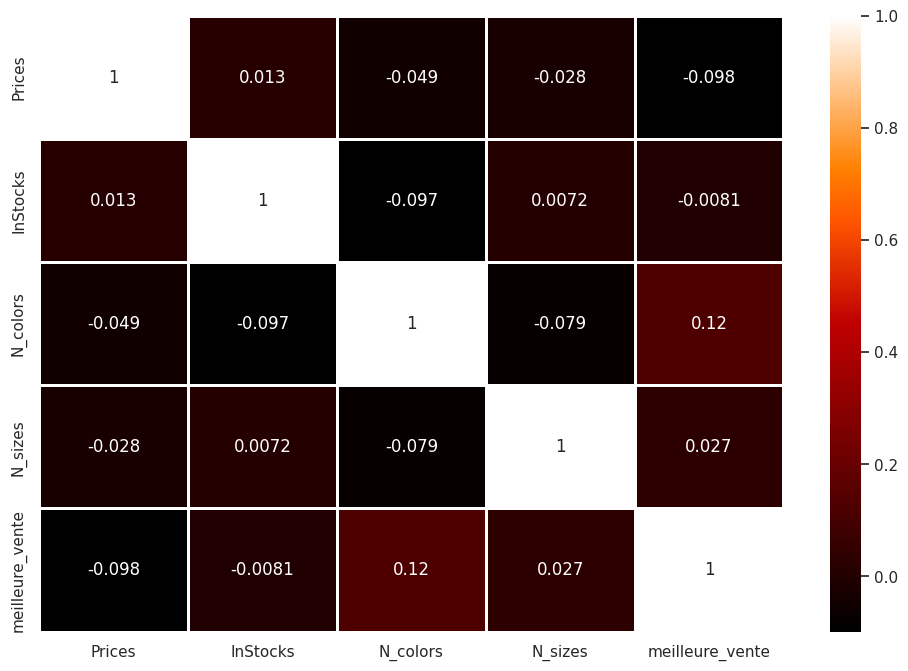

In [18]:
plt.figure(figsize=(12,8)) 
sns.heatmap(df_collection.corr(), annot=True, cmap='gist_heat', linewidths = 2)
plt.show()

In [19]:

# Créez un pie chart avec Plotly Express
fig = px.pie(df_collection, names='InStocks', title='Proportion des articles en stocks', hole=0.3)

# Affichez le graphique
fig.show()


In [20]:

# Créez un pie chart avec Plotly Express
fig = px.pie(df_collection, names='meilleure_vente', title='Proporttion des meilleurs ventes', hole=0.3)

# Affichez le graphique
fig.show()


In [21]:
# Proportion d'articles en stock vendu 
df_collection.groupby(['meilleure_vente','InStocks']).count()['Articles']

meilleure_vente  InStocks
False            False         13
                 True         689
True             False         48
                 True        2214
Name: Articles, dtype: int64

In [22]:

# Créez un graphique à barres empilées avec Plotly Express
fig = px.histogram(
    df_collection,
    x='meilleure_vente',
    color='InStocks',
    nbins=len(df_collection['meilleure_vente'].unique()),
    title="Nombre d'articles par catégorie de meilleure vente et disponibilité en stock",
    labels={'meilleure_vente': 'Meilleure Vente', 'InStocks': 'En Stock'},
    barmode='group'
)

# Affichez le graphique
fig.show()


In [23]:
# Proportion d'articles disponible en stocks faisant partie des meilleurs ventes
dt=df_collection[(df_collection.meilleure_vente==1)&(df_collection.InStocks==1)]
dt.groupby(['meilleure_vente','InStocks']).count()['Articles']

meilleure_vente  InStocks
True             True        2214
Name: Articles, dtype: int64

In [24]:
df_collection.groupby(['N_colors','meilleure_vente']).nunique()['Articles']

N_colors  meilleure_vente
1         False              112
          True               210
2         False              105
          True               227
3         False              121
          True               287
4         False              126
          True               326
5         False              107
          True               358
6         False               76
          True               293
7         False               30
          True               168
8         False                5
          True                69
9         False                4
          True                34
10        False                1
          True                13
11        True                10
12        False                2
          True                 3
13        False                1
          True                 1
15        True                 1
17        False                1
18        False                1
19        True                 1
Name: Articles, d

<AxesSubplot: xlabel='N_colors', ylabel='count'>

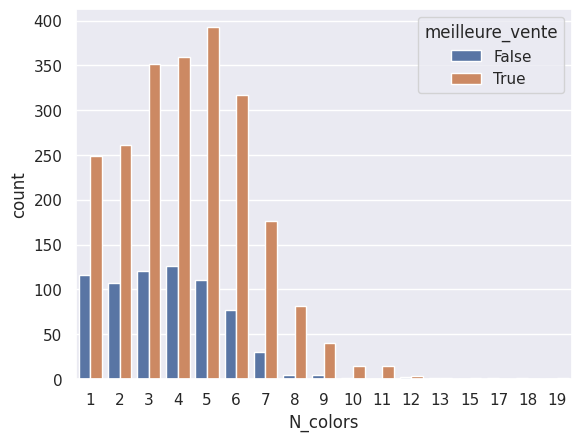

In [25]:
sns.countplot(data=df_collection, x='N_colors',hue='meilleure_vente')

In [26]:
new_df = df_collection.copy()

for c in bool_features :
    encoder = LabelEncoder()
    encoder.fit(list(new_df[c]))
    new_df[c] = encoder.transform(new_df[c])
    

In [27]:
print([new_df[a].unique() for a in bool_features])

[array([1, 0]), array([1, 0])]


In [28]:
new_df.head()

,Articles,Prices,InStocks,N_colors,N_sizes,meilleure_vente
0,Robe sexy en simili cuir...,31.92,1,4,3,1
1,Robe tendance dos nu,21.84,1,4,3,0
2,Robe en jeans tendance avec...,31.92,1,1,4,1
3,Robe en jeans tendance avec...,31.92,1,1,4,1
4,Mini robe sexy à manches...,21.84,1,6,1,1


In [29]:
new_df.skew()

Prices             22.936989
InStocks           -6.757025
N_colors            0.725320
N_sizes             0.598249
meilleure_vente    -1.238596
dtype: float64

In [30]:

#histogramme avec Plotly Express
fig = px.histogram(
    new_df,
    x='meilleure_vente',
    color='meilleure_vente',
    nbins=len(new_df['meilleure_vente'].unique()),
    title='Diagramme à barres',
    labels={'meilleure_vente': 'Meilleure Vente'},
    barmode='group'
)


fig.show()

# valeurs uniques de la colonne 'meilleure_vente'
value_counts = new_df['meilleure_vente'].value_counts()
M = value_counts[0]
B = value_counts[1]

print("Nombre d'articles moins vendus : ", M)
print("Nombre d'articles bien vendus :", B)


Nombre d'articles moins vendus :  702
Nombre d'articles bien vendus : 2262


In [31]:
# histogramme avec Plotly Express
fig = px.histogram(
    new_df,
    x='InStocks',
    color='InStocks',
    nbins=len(new_df['InStocks'].unique()),
    title='Diagramme à barres',
    labels={'InStocks': 'En Stock'},
    barmode='group'
)

fig.show()

# valeurs uniques de la colonne 'InStocks'
value_counts = new_df['InStocks'].value_counts()
M = value_counts[0]
B = value_counts[1]

print("Nombre d'articles moins vendus : ", M)
print("Nombre d'articles bien vendus :", B)


Nombre d'articles moins vendus :  61
Nombre d'articles bien vendus : 2903


Cette analyse exploratoire nous a permis de mieux comprendre et nous a aussi permis de connaitre les types de prétraitement que nous pouvons opérer afin de préparer les données pour la phase de modélisation.

Commençons par la variable cible **meilleure_vente** et divisons  la dataframe en données d'entraînement et d'évaluation.

## Modélisation

Rappellons que les poportions de notre variable target est:
- Nombre d'articles moins vendus :  702
- Nombre d'articles bien vendus : 2262

Pour diviser le jeu de données en ensembles d'entraînement et de test tout en maintenant la proportion de la variable cible, on utilisera l'argument stratify. 

In [32]:
scaler = StandardScaler()

K= new_df[["Prices"]]
K = scaler.fit_transform(K)
new_df[["Prices"]] = K

new_df.head()

,Articles,Prices,InStocks,N_colors,N_sizes,meilleure_vente
0,Robe sexy en simili cuir...,0.018252,1,4,3,1
1,Robe tendance dos nu,-0.033757,1,4,3,0
2,Robe en jeans tendance avec...,0.018252,1,1,4,1
3,Robe en jeans tendance avec...,0.018252,1,1,4,1
4,Mini robe sexy à manches...,-0.033757,1,6,1,1


In [33]:
from sklearn.model_selection import train_test_split
# variables d'entrée (X) et la variable cible (y)
y = new_df['meilleure_vente']
X = new_df.drop(['meilleure_vente','Articles'], axis=1)

# Division des données en ensembles d'entraînement, de validation et de test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size = 0.5, random_state = 42, stratify=y_tmp)


# répartition des données
print("Proportion de la variable cible dans l'ensemble d'entraînement :\n", y_train.value_counts(normalize=True))
print("Proportion de la variable cible dans l'ensemble de validation :\n", y_val.value_counts(normalize=True))
print("Proportion de la variable cible dans l'ensemble de test :\n", y_test.value_counts(normalize=True))
print("-----------------------------------------------------------------------------------------------")
print('data shape{}'.format(new_df.shape))
print('Train shape {}'.format(X_train.shape))
print('Validation shape {}'.format(X_val.shape))
print('Test shape {}'.format(X_test.shape))

Proportion de la variable cible dans l'ensemble d'entraînement :
 1    0.763259
0    0.236741
Name: meilleure_vente, dtype: float64
Proportion de la variable cible dans l'ensemble de validation :
 1    0.764045
0    0.235955
Name: meilleure_vente, dtype: float64
Proportion de la variable cible dans l'ensemble de test :
 1    0.761798
0    0.238202
Name: meilleure_vente, dtype: float64
-----------------------------------------------------------------------------------------------
data shape(2964, 6)
Train shape (2074, 4)
Validation shape (445, 4)
Test shape (445, 4)


Nous sommes face à un problème d'optimoisation de l'approvisionement en vêtement des magasin. Parmi les algorithmes de classification les plus utilisés nous portons nos choix sur les suivants: 

- **Logistic Regression** : La régression logistique est un bon point de départ pour les problèmes de classification binaire. Elle est simple, rapide et fonctionne bien lorsque les relations entre les variables d'entrée et la variable cible sont linéaires.

- **Random Forest Classifier** : Les forêts aléatoires sont robustes aux outliers, peuvent capturer des relations non linéaires et fonctionnent bien avec un nombre modéré de variables d'entrée. De plus, ils sont généralement moins sensibles au surajustement que les arbres de décision individuels.

- **Extreme Gradient Boost** : Ce modèle est une amélioration du gradient boosting et est généralement très performant pour les problèmes de classification binaire. Il peut capturer des relations non linéaires et est robuste face aux outliers.

- **Support Vector Machine** : Les machines à vecteurs de support peuvent être efficaces pour les problèmes de classification binaire avec un petit nombre de variables d'entrée. Il est important de choisir le bon noyau pour capturer les relations non linéaires entre les variables.

- **K-Nearest Neighbour** : Bien que le KNN soit généralement plus adapté aux problèmes avec un grand nombre de variables, il peut toujours être utile pour les problèmes avec un nombre modéré de variables d'entrée. Il peut capturer des relations non linéaires, mais il est important de choisir la bonne métrique de distance et le bon nombre de voisins.

In [34]:
def rmse(preds, targets):
    return np.sqrt(((preds - targets) ** 2).mean())


def Ml_model(X_train, X_test, y_train, y_test,mod):
    accuracies = {}
    f1_sc = {}
    precision_sc = {}
    recall_sc ={}
    root_mean = {}
    for name,clf in mod.items():
        clf.fit(X_train,y_train)

        acc = accuracy_score(clf.predict(X_test),y_test)*100
        accuracies[name] = np.round(acc,2)

        f1 = f1_score(clf.predict(X_test),y_test)*100
        f1_sc[name] = np.round(f1,2)

        root = rmse(clf.predict(X_test),y_test)*100
        root_mean[name] = np.round(root,2)
    return [accuracies,f1_sc,root_mean]

In [35]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
models = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5),
    'SupportVectorMachine': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors = 10,weights = 'uniform',algorithm = 'auto',p = 2),
    'XGBClassifier': XGBClassifier()
}

modelNames = ['LogisticRegression','RandomForestClassifier','SupportVectorMachine', 'KNeighborsClassifier','XGBClassifier']

LogisticRegression
Train score of trained model: 76.66345226615236
Validation score of trained model: 76.62921348314606
Test score of trained model: 76.85393258426966
 
Confussion Matrix: 
[[  4   1]
 [102 338]]

Accuracy : 0.7685393258426966
Precision: 0.9970501474926253
Recall   : 0.7681818181818182
F1 score : 0.8677792041078306
Specificity : 0.8

Classification Report: 
              precision    recall  f1-score   support

           0       0.04      0.80      0.07         5
           1       1.00      0.77      0.87       440

    accuracy                           0.77       445
   macro avg       0.52      0.78      0.47       445
weighted avg       0.99      0.77      0.86       445



############################################################################



RandomForestClassifier
Train score of trained model: 77.43490838958535
Validation score of trained model: 75.95505617977528
Test score of trained model: 77.30337078651685
 
Confussion Matrix: 
[[  6   1]
 [100 338]]

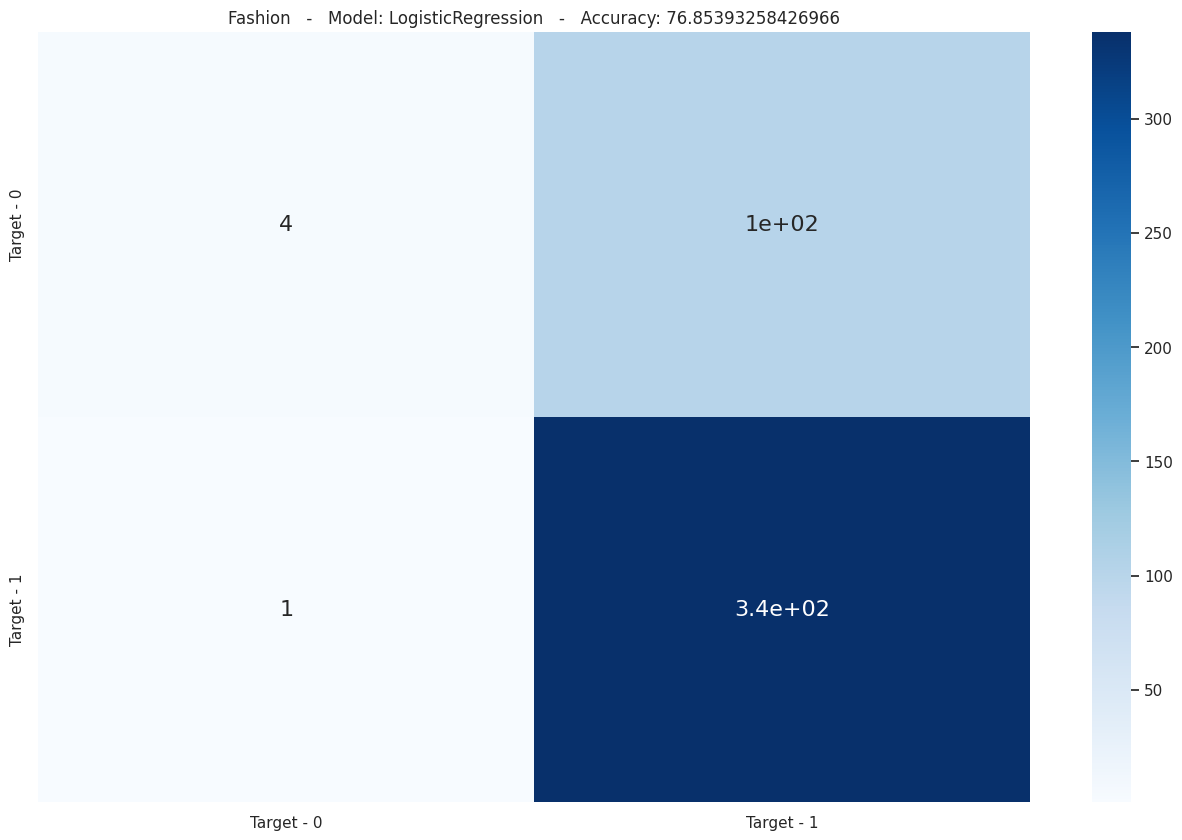

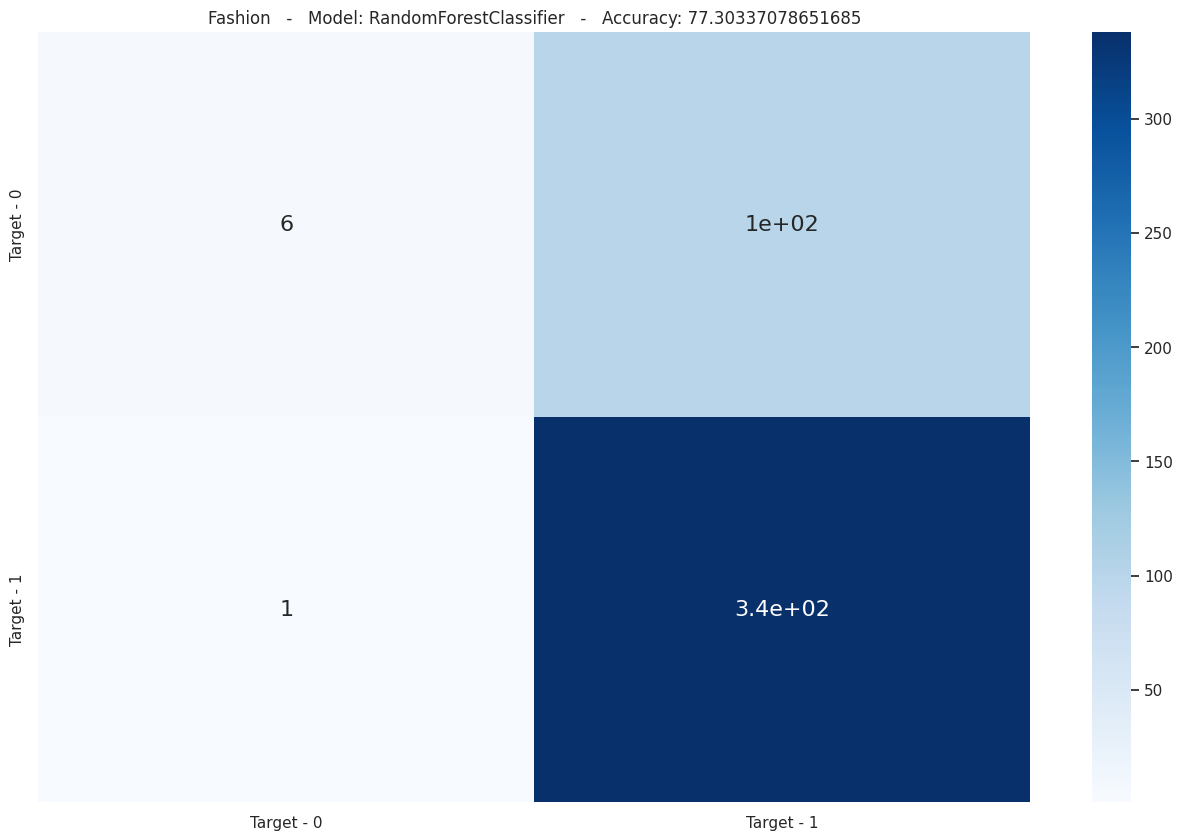

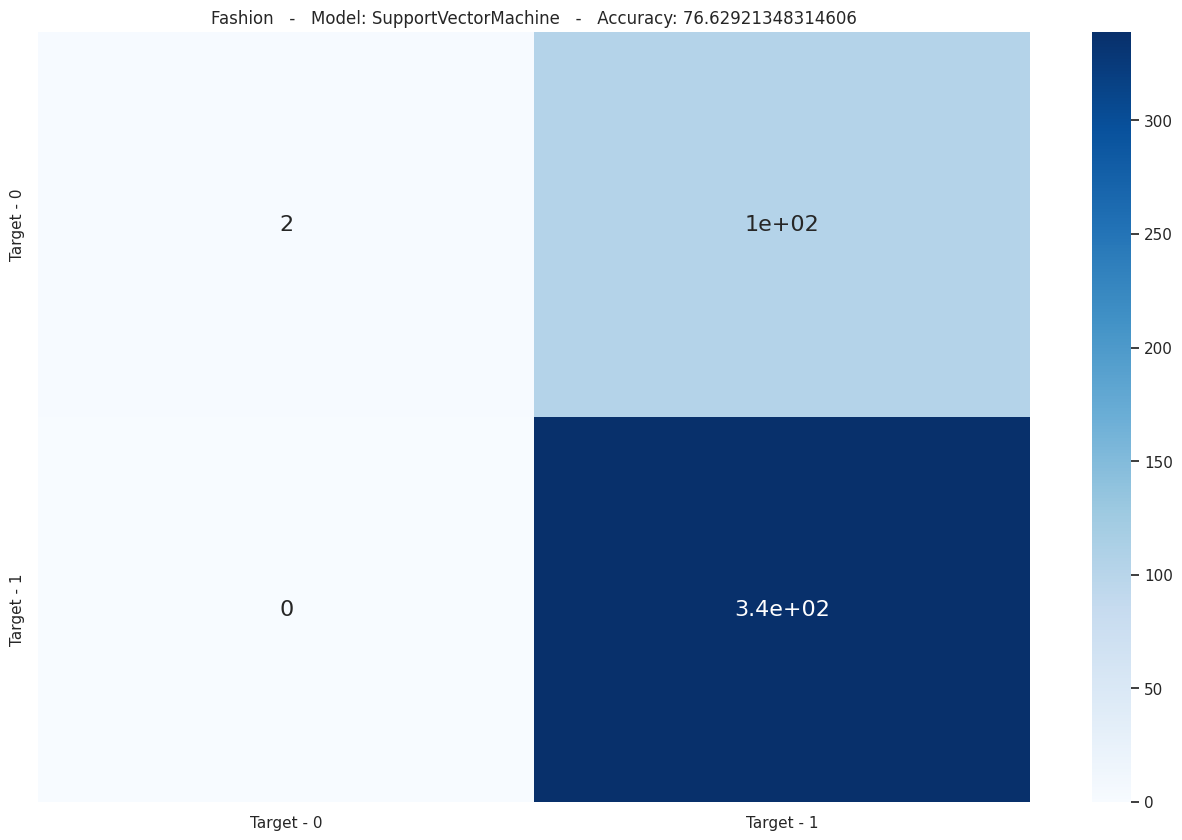

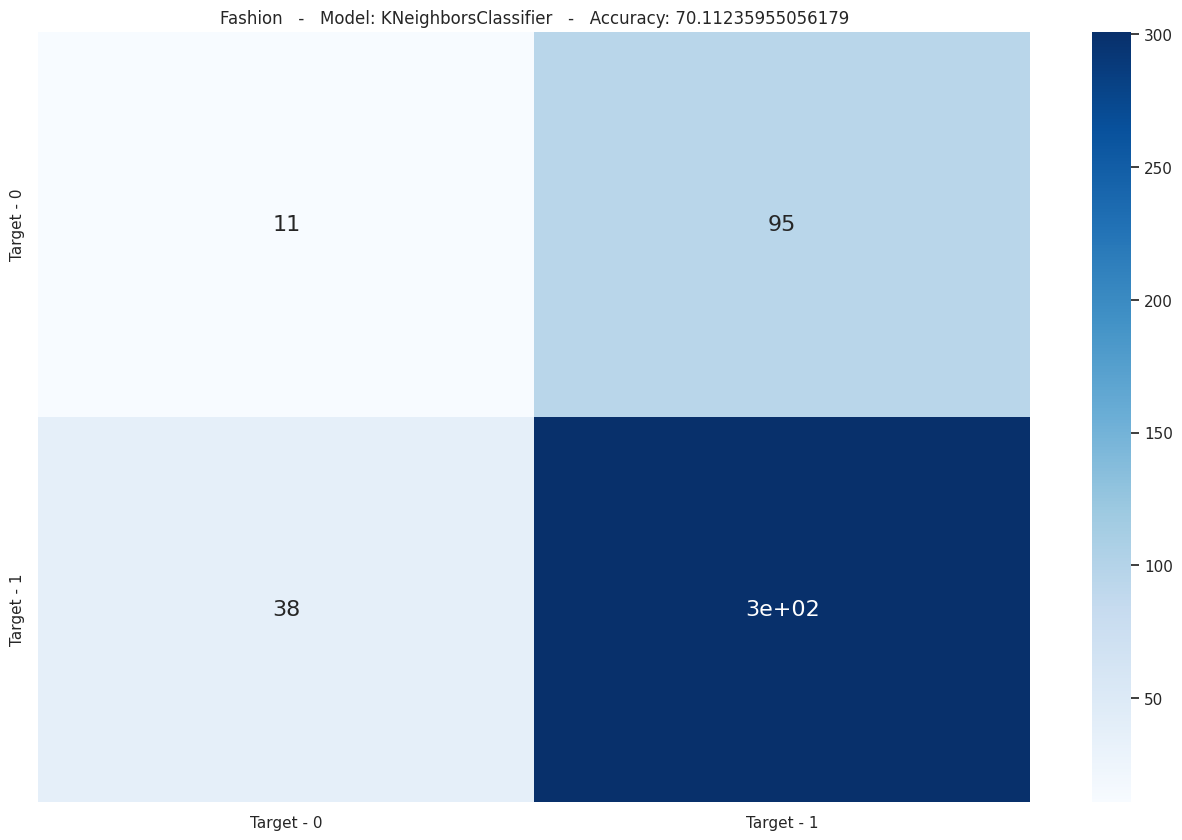

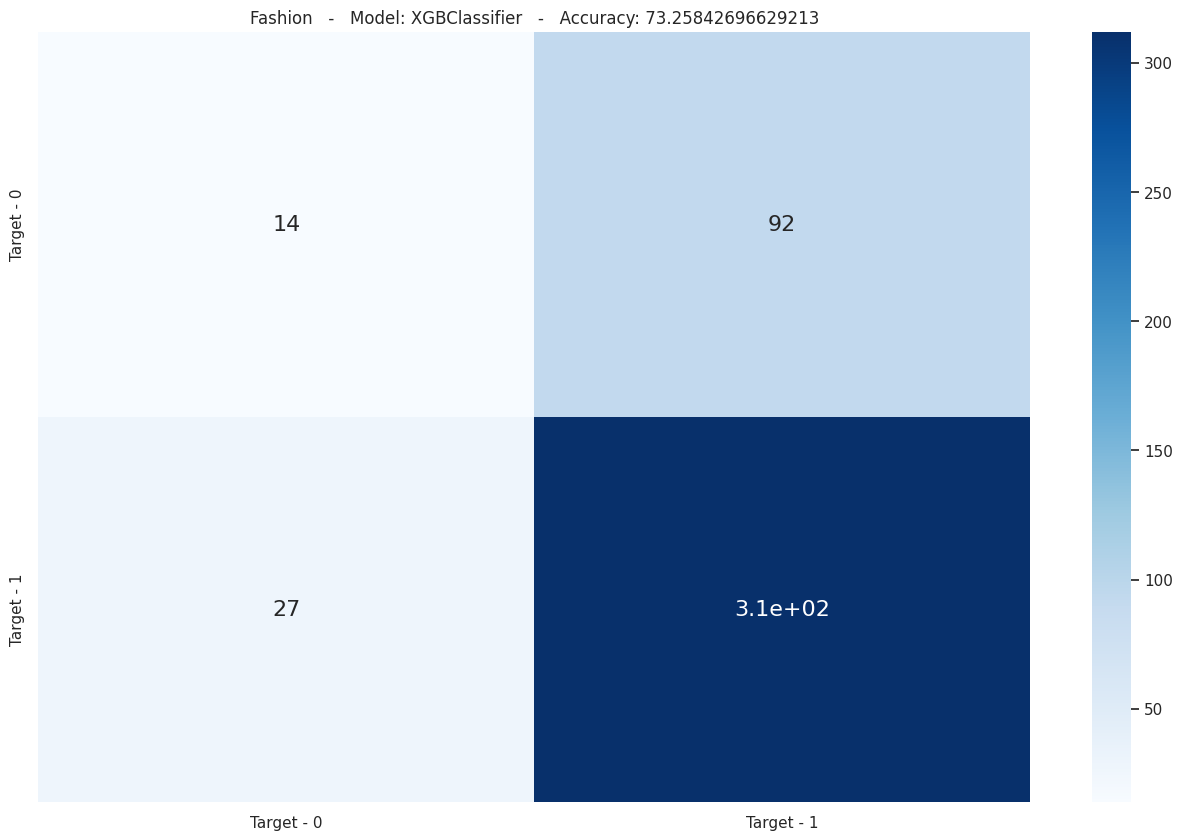

In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
trainScores = []
validationScores = []
testScores = []

for m in models:
  model = models[m]
  model.fit(X_train, y_train)
  score = model.score(X_val, y_val)
  #print(f'{m} validation score => {score*100}')
    
  print(f'{m}') 
  train_score = model.score(X_train, y_train)
  print(f'Train score of trained model: {train_score*100}')
  trainScores.append(train_score*100)

  validation_score = model.score(X_val, y_val)
  print(f'Validation score of trained model: {validation_score*100}')
  validationScores.append(validation_score*100)

  test_score = model.score(X_test, y_test)
  print(f'Test score of trained model: {test_score*100}')
  testScores.append(test_score*100)
  print(" ")
    
  y_predictions = model.predict(X_test)
  conf_matrix = confusion_matrix(y_predictions, y_test)

  print(f'Confussion Matrix: \n{conf_matrix}\n')

  predictions = model.predict(X_test)
  cm = confusion_matrix(predictions, y_test)

  tn = conf_matrix[0,0]
  fp = conf_matrix[0,1]
  tp = conf_matrix[1,1]
  fn = conf_matrix[1,0]
  accuracy  = (tp + tn) / (tp + fp + tn + fn)
  precision = tp / (tp + fp)
  recall    = tp / (tp + fn)
  f1score  = 2 * precision * recall / (precision + recall)
  specificity = tn / (tn + fp)
  print(f'Accuracy : {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall   : {recall}')
  print(f'F1 score : {f1score}')
  print(f'Specificity : {specificity}')
  print("") 
  print(f'Classification Report: \n{classification_report(predictions, y_test)}\n')
  print("")
   
  for m in range (1):
    current = modelNames[m]
    modelNames.remove(modelNames[m])

  preds = model.predict(X_test)
  confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
  plt.figure(figsize = (16,10))
  plt.title(f'Fashion   -   Model: {current}   -   Accuracy: {test_score*100}')
  sns.heatmap(confusion_matr, cmap="Blues", annot=True, annot_kws={"size": 16},
              xticklabels = ['Target - 0', 'Target - 1'],
             yticklabels=['Target - 0', 'Target - 1']);
  #plt.savefig(f'{current}.jpg')
  print("############################################################################")
  print("")
  print("")
  print("")

In [37]:

from sklearn.svm import SVC
models = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5),
    'SupportVectorMachine': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors = 10,weights = 'uniform',algorithm = 'auto',p = 2),
    'XGBClassifier': XGBClassifier()
}

modelNames = ['LogisticRegression','RandomForestClassifier','SupportVectorMachine', 'KNeighborsClassifier','XGBClassifier']

In [38]:
for i in range(4):
    print(f'Accuracy of {modelNames[i]} -----> {testScores[i]}')

Accuracy of LogisticRegression -----> 76.85393258426966
Accuracy of RandomForestClassifier -----> 77.30337078651685
Accuracy of SupportVectorMachine -----> 76.62921348314606
Accuracy of KNeighborsClassifier -----> 70.11235955056179


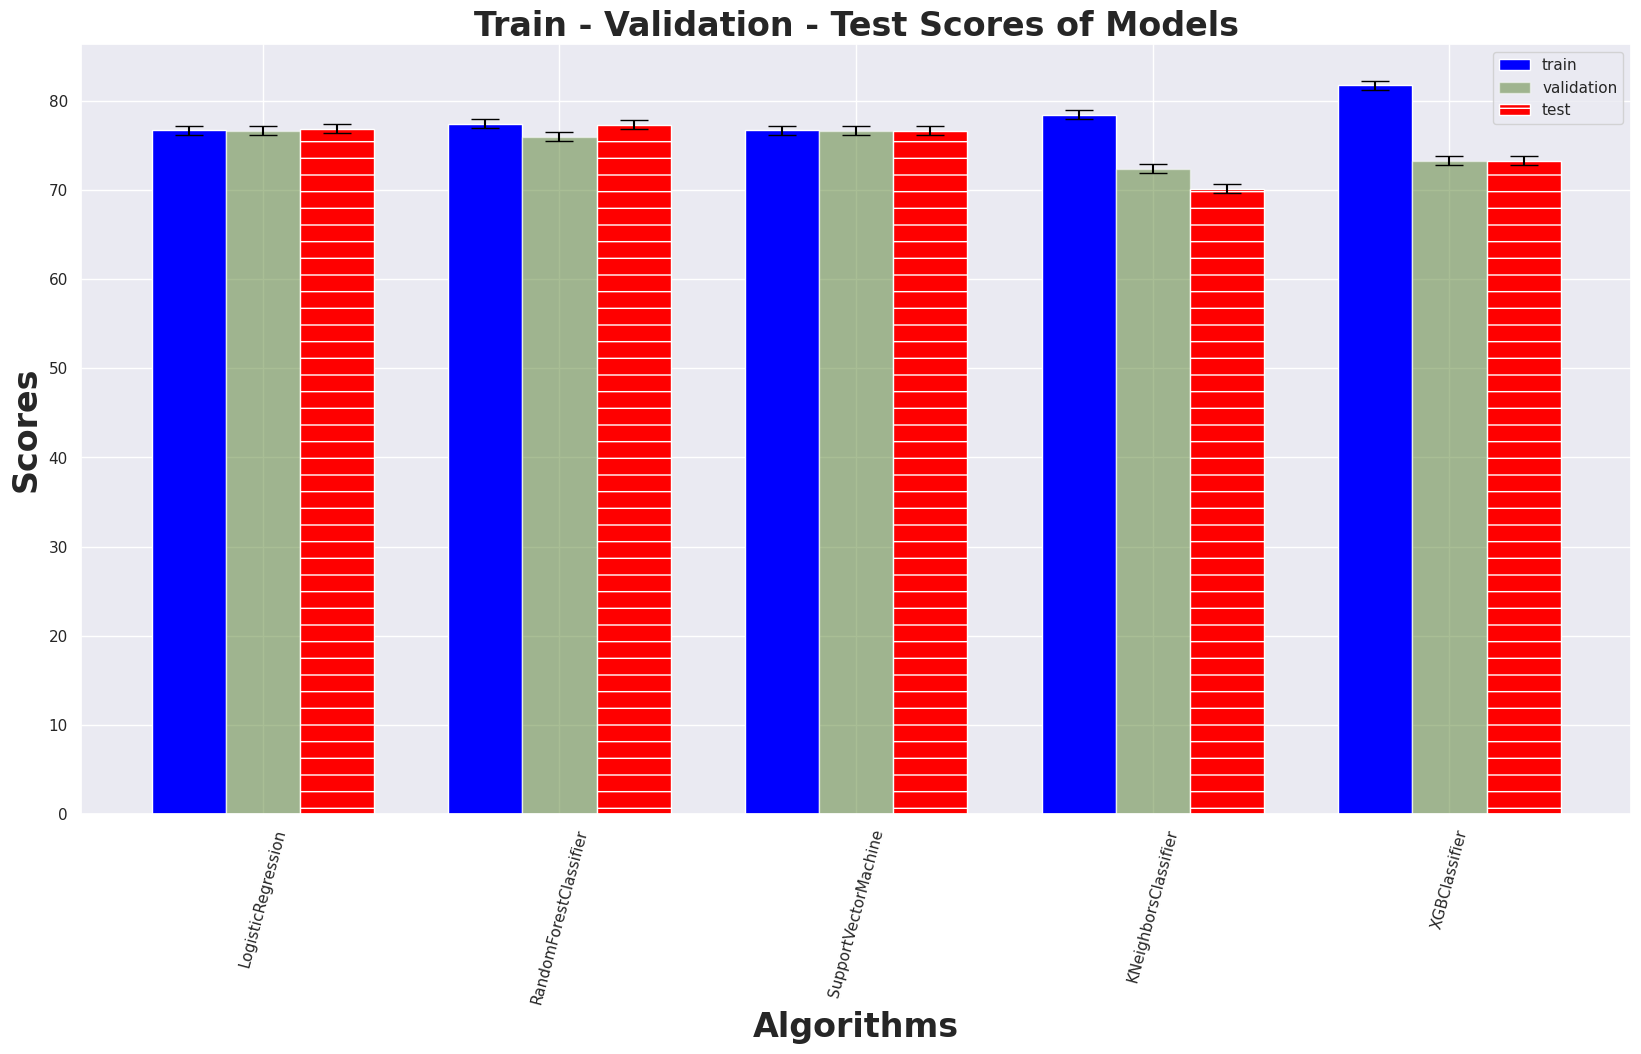

In [39]:
plt.figure(figsize=(20,10))
plt.title('Train - Validation - Test Scores of Models', fontweight='bold', size = 24)

barWidth = 0.25
 
bars1 = trainScores
bars2 = validationScores
bars3 = testScores
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
plt.bar(r1, bars1, color='blue', width=barWidth, edgecolor='white', label='train', yerr=0.5,ecolor="black",capsize=10)
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='validation', yerr=0.5,ecolor="black",capsize=10, alpha = .50)
plt.bar(r3, bars3, color='red', width=barWidth, edgecolor='white', label='test', yerr=0.5,ecolor="black",capsize=10, hatch = '-')
 

    
plt.xlabel('Algorithms', fontweight='bold', size = 24)
plt.ylabel('Scores', fontweight='bold', size = 24)
plt.xticks([r + barWidth for r in range(len(bars1))], modelNames, rotation = 75)
 
plt.legend()
plt.savefig('Train - Validation - Test Scores of Models')
plt.show()

In [40]:
from sklearn.metrics import accuracy_score

pd.DataFrame(
    Ml_model(X_train, X_test, y_train, y_test, models),
    index=["Accuracy", "F1_score", "Rmse"],
)


,LogisticRegression,RandomForestClassifier,SupportVectorMachine,KNeighborsClassifier,XGBClassifier
Accuracy,76.85,77.30,76.63,70.11,73.26
F1_score,86.78,87.00,86.70,81.90,83.98
Rmse,48.11,47.64,48.34,54.67,51.71


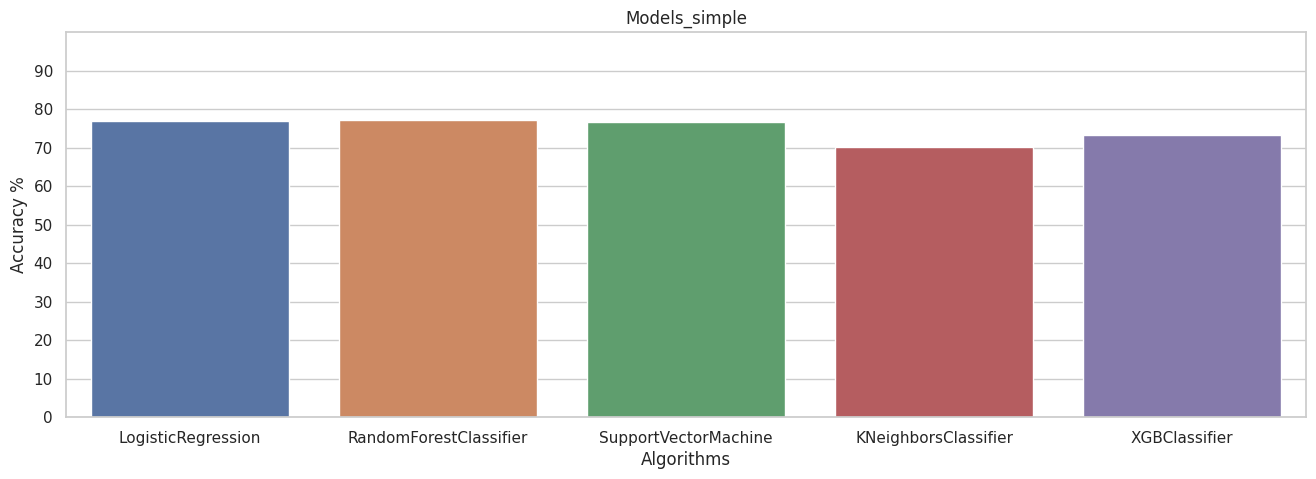

In [41]:
from sklearn.metrics import f1_score
Accuracies=Ml_model(X_train, X_test, y_train, y_test,models)[0]

#colors = ["green", "orange",,"blue","yellow","red"]
sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylim(0,100)
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(Accuracies.keys()), y=list(Accuracies.values()))
plt.savefig('Models_simple.png')
plt.title('Models_simple')
plt.show()

## Optimisation des hyperparamètres

Recherche des hyperparamètres les plus influents pour la régression logistique.

In [43]:

# Définir les hyperparamètres à optimiser
hyperparameters = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(2, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialiser le modèle RandomForestClassifier
model = RandomForestClassifier()

# Créer l'objet RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=hyperparameters,
    n_iter=20,  # Nombre d'itérations de la recherche aléatoire
    cv=10,  # Nombre de folds pour la validation croisée
    random_state=42
)

# Effectuer la recherche aléatoire sur les hyperparamètres
random_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et le meilleur score obtenu
print("Meilleurs hyperparamètres :")
print(random_search.best_params_)
print("Meilleur score :")
print(random_search.best_score_)


Meilleurs hyperparamètres :
{'bootstrap': True, 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 826}
Meilleur score :
0.7656888703084356


In [44]:
# Utiliser les meilleurs hyperparamètres pour créer le modèle avec les nouveaux paramètres
best_model = RandomForestClassifier(**random_search.best_params_)

# Entraîner le modèle sur l'ensemble d'entraînement complet (y compris les données de validation)
best_model.fit(X_train, y_train)

# Faire des prédictions sur le jeu de validation
y_pred = best_model.predict(X_val)

# Évaluer les performances du modèle sur le jeu de validation
accuracy = accuracy_score(y_val, y_pred)
print("Précision sur le jeu de validation :", accuracy)

Précision sur le jeu de validation : 0.748314606741573


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2b676dad-e098-4ec8-b5a3-837be1c21a57' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>